In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN

# Load results

In [464]:
def load_data(name, protected):
    if protected:
        path = "protected/" + name
    else:
        path = "unprotected/" + name
    results = dict()
    results["K"] = np.load("results/" + path + "/K.npy")

    results["mae_all_userknn"] = np.load("results/" + path + "/mae_all_userknn.npy")
    results["mae_all_pop"] = np.load("results/" + path + "/mae_all_pop.npy")
    results["mae_all_gain"] = np.load("results/" + path + "/mae_all_gain.npy")
    results["mae_all_userknn_reuse"] = np.load("results/" + path + "/mae_all_userknn_reuse.npy")
    results["mae_all_pop_reuse"] = np.load("results/" + path + "/mae_all_pop_reuse.npy")
    results["mae_all_gain_reuse"] = np.load("results/" + path + "/mae_all_gain_reuse.npy")
    
    results["mae_below_userknn"] = np.load("results/" + path + "/mae_below_userknn.npy")
    results["mae_below_pop"] = np.load("results/" + path + "/mae_below_pop.npy")
    results["mae_below_gain"] = np.load("results/" + path + "/mae_below_gain.npy")
    results["mae_below_userknn_reuse"] = np.load("results/" + path + "/mae_below_userknn_reuse.npy")
    results["mae_below_pop_reuse"] = np.load("results/" + path + "/mae_below_pop_reuse.npy")
    results["mae_below_gain_reuse"] = np.load("results/" + path + "/mae_below_gain_reuse.npy")
    
    results["mae_above_userknn"] = np.load("results/" + path + "/mae_above_userknn.npy")
    results["mae_above_pop"] = np.load("results/" + path + "/mae_above_pop.npy")
    results["mae_above_gain"] = np.load("results/" + path + "/mae_above_gain.npy")
    results["mae_above_userknn_reuse"] = np.load("results/" + path + "/mae_above_userknn_reuse.npy")
    results["mae_above_pop_reuse"] = np.load("results/" + path + "/mae_above_pop_reuse.npy")
    results["mae_above_gain_reuse"] = np.load("results/" + path + "/mae_above_gain_reuse.npy")

    results["pr_all_userknn"] = np.load("results/" + path + "/pr_all_userknn.npy")
    results["pr_all_pop"] = np.load("results/" + path + "/pr_all_pop.npy")
    results["pr_all_gain"] = np.load("results/" + path + "/pr_all_gain.npy")
    results["pr_all_userknn_reuse"] = np.load("results/" + path + "/pr_all_userknn_reuse.npy")
    results["pr_all_pop_reuse"] = np.load("results/" + path + "/pr_all_pop_reuse.npy")
    results["pr_all_gain_reuse"] = np.load("results/" + path + "/pr_all_gain_reuse.npy")
    
    results["pr_below_userknn"] = np.load("results/" + path + "/pr_below_userknn.npy")
    results["pr_below_pop"] = np.load("results/" + path + "/pr_below_pop.npy")
    results["pr_below_gain"] = np.load("results/" + path + "/pr_below_gain.npy")
    results["pr_below_userknn_reuse"] = np.load("results/" + path + "/pr_below_userknn_reuse.npy")
    results["pr_below_pop_reuse"] = np.load("results/" + path + "/pr_below_pop_reuse.npy")
    results["pr_below_gain_reuse"] = np.load("results/" + path + "/pr_below_gain_reuse.npy")
    
    results["pr_above_userknn"] = np.load("results/" + path + "/pr_above_userknn.npy")
    results["pr_above_pop"] = np.load("results/" + path + "/pr_above_pop.npy")
    results["pr_above_gain"] = np.load("results/" + path + "/pr_above_gain.npy")
    results["pr_above_userknn_reuse"] = np.load("results/" + path + "/pr_above_userknn_reuse.npy")
    results["pr_above_pop_reuse"] = np.load("results/" + path + "/pr_above_pop_reuse.npy")
    results["pr_above_gain_reuse"] = np.load("results/" + path + "/pr_above_gain_reuse.npy")
    
    results["vulnerables_userknn"] = np.load("results/" + path + "/vulnerables_userknn.npy")
    results["vulnerables_pop"] = np.load("results/" + path + "/vulnerables_pop.npy")
    results["vulnerables_gain"] = np.load("results/" + path + "/vulnerables_gain.npy")
    results["vulnerables_userknn_reuse"] = np.load("results/" + path + "/vulnerables_userknn_reuse.npy")
    results["vulnerables_pop_reuse"] = np.load("results/" + path + "/vulnerables_pop_reuse.npy")
    results["vulnerables_gain_reuse"] = np.load("results/" + path + "/vulnerables_gain_reuse.npy")
    
    if protected:
        results["nr_noisy_ratings_userknn"] = np.load("results/" + path + "/nr_noisy_ratings_userknn.npy")
        results["nr_noisy_ratings_pop"] = np.load("results/" + path + "/nr_noisy_ratings_pop.npy")
        results["nr_noisy_ratings_gain"] = np.load("results/" + path + "/nr_noisy_ratings_gain.npy")
        results["nr_noisy_ratings_userknn_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_userknn_reuse.npy")
        results["nr_noisy_ratings_pop_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_pop_reuse.npy")
        results["nr_noisy_ratings_gain_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_gain_reuse.npy")
    
    return results

In [407]:
%matplotlib inline

In [446]:
def plot_mae_pr(ax, results, group="all"):
    ax.plot(results["mae_" + group + "_userknn"], results["pr_" + group + "_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_" + group + "_pop"], results["pr_" + group + "_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_" + group + "_gain"], results["pr_" + group + "_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_" + group + "_userknn_reuse"], results["pr_" + group + "_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["mae_" + group + "_pop_reuse"], results["pr_" + group + "_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["mae_" + group + "_gain_reuse"], results["pr_" + group + "_gain_reuse"], color="C2", linestyle="solid")

"""def plot_vulnerables(ax, results):
    ax.plot(results["mae_userknn"], results["vuln_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_pop"], results["vuln_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_gain"], results["vuln_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_userknn_reuse"], results["vuln_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["mae_pop_reuse"], results["vuln_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["mae_gain_reuse"], results["vuln_gain_reuse"], color="C2", linestyle="solid")"""

'def plot_vulnerables(ax, results):\n    ax.plot(results["mae_userknn"], results["vuln_userknn"], color="C0", linestyle="dashed", alpha=0.5)\n    ax.plot(results["mae_pop"], results["vuln_pop"], color="C1", linestyle="dashed", alpha=0.5)\n    ax.plot(results["mae_gain"], results["vuln_gain"], color="C2", linestyle="dashed", alpha=0.5)\n    ax.plot(results["mae_userknn_reuse"], results["vuln_userknn_reuse"], color="C0", linestyle="solid")\n    ax.plot(results["mae_pop_reuse"], results["vuln_pop_reuse"], color="C1", linestyle="solid")\n    ax.plot(results["mae_gain_reuse"], results["vuln_gain_reuse"], color="C2", linestyle="solid")'

In [481]:
%matplotlib inline

# k vs. accuracy
## all users, unprotected

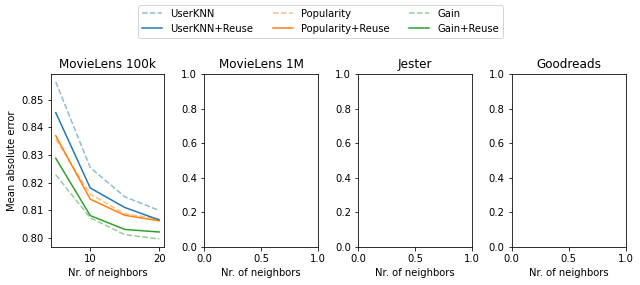

In [482]:
ml100k_results = load_data(name="ml-100k", protected=False)
ml1m_results = load_data(name="ml-100k", protected=False)#load_data(name="ml-1m", protected=False)
jester_results = load_data(name="ml-100k", protected=False)#load_data(name="jester", protected=False)
goodreads_results = load_data(name="ml-100k", protected=False)#load_data(name="goodreads", protected=False)

def plot_k_mae(ax, results):
    ax.plot(results["K"], results["mae_all_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["K"], results["mae_all_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["K"], results["mae_all_gain_reuse"], color="C2", linestyle="solid")

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_k_mae(axes[0], ml100k_results)
#plot_k_mae(axes[1], ml1m_results)
#plot_k_mae(axes[2], jester_results)
#plot_k_mae(axes[3], goodreads_results)

axes[0].set_ylabel("Mean absolute error")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

## all users, protected

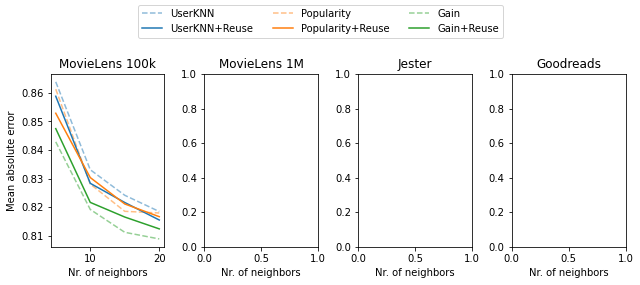

In [483]:
ml100k_results = load_data(name="ml-100k", protected=True)
ml1m_results = load_data(name="ml-100k", protected=True)#load_data(name="ml-1m", protected=False)
jester_results = load_data(name="ml-100k", protected=True)#load_data(name="jester", protected=False)
goodreads_results = load_data(name="ml-100k", protected=True)#load_data(name="goodreads", protected=False)

def plot_k_mae(ax, results):
    ax.plot(results["K"], results["mae_all_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["K"], results["mae_all_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["K"], results["mae_all_gain_reuse"], color="C2", linestyle="solid")

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_k_mae(axes[0], ml100k_results)
#plot_k_mae(axes[1], ml1m_results)
#plot_k_mae(axes[2], jester_results)
#plot_k_mae(axes[3], goodreads_results)

axes[0].set_ylabel("Mean absolute error")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

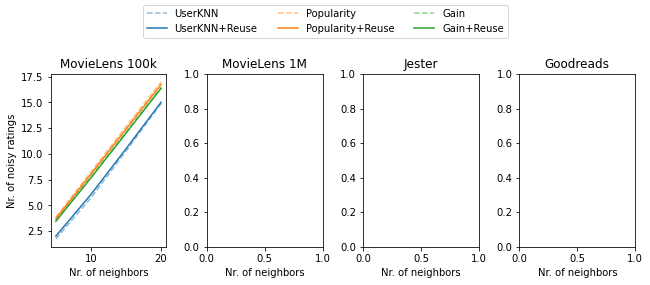

In [484]:
ml100k_results = load_data(name="ml-100k", protected=True)
ml1m_results = load_data(name="ml-100k", protected=True)#load_data(name="ml-1m", protected=False)
jester_results = load_data(name="ml-100k", protected=True)#load_data(name="jester", protected=False)
goodreads_results = load_data(name="ml-100k", protected=True)#load_data(name="goodreads", protected=False)

def plot_noisy_ratings_k(ax, results):
    ax.plot(results["K"], results["nr_noisy_ratings_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["nr_noisy_ratings_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["nr_noisy_ratings_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["nr_noisy_ratings_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["K"], results["nr_noisy_ratings_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["K"], results["nr_noisy_ratings_gain_reuse"], color="C2", linestyle="solid")

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_noisy_ratings_k(axes[0], ml100k_results)
#plot_noisy_ratings_k(axes[1], ml1m_results)
#plot_noisy_ratings_k(axes[2], jester_results)
#plot_noisy_ratings_k(axes[3], goodreads_results)

axes[0].set_ylabel("Nr. of noisy ratings")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

## accuracy vs. privacy risk [all users, protected, privacy risk of vulnerables set to 0]

In [485]:
def plot_mae_pr(ax, results):
    ax.plot(results["mae_all_userknn"], results["pr_below_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_pop"], results["pr_below_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_gain"], results["pr_below_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_userknn_reuse"], results["pr_below_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["mae_all_pop_reuse"], results["pr_below_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["mae_all_gain_reuse"], results["pr_below_gain_reuse"], color="C2", linestyle="solid")

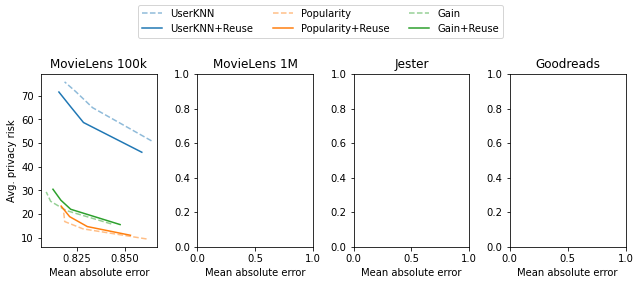

In [486]:
ml100k_results = load_data(name="ml-100k", protected=True)
ml1m_results = load_data(name="ml-100k", protected=True)#load_data(name="ml-1m", protected=False)
jester_results = load_data(name="ml-100k", protected=True)#load_data(name="jester", protected=False)
goodreads_results = load_data(name="ml-100k", protected=True)#load_data(name="goodreads", protected=False)

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_mae_pr(axes[0], ml100k_results)
#plot_mae_pr(axes[1], ml1m_results)
#plot_mae_pr(axes[2], jester_results)
#plot_mae_pr(axes[3], goodreads_results)

axes[0].set_ylabel("Avg. privacy risk")
axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[2].set_xlabel("Mean absolute error")
axes[3].set_xlabel("Mean absolute error")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

# trade-off protected secure users

In [402]:
ml100k_results = load_data("/protected/ml-100k")
ml1m_results = load_data("/protected/ml-1m")
jester_results = load_data("/protected/jester")
goodreads_results = load_data("/protected/goodreads")
fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_exposure(axes[0], ml100k_results, only_below=True)
plot_exposure(axes[1], ml1m_results, only_below=True)
plot_exposure(axes[2], jester_results, only_below=True)
plot_exposure(axes[3], goodreads_results, only_below=True)

axes[0].set_ylabel("Avg. privacy risk")
axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[2].set_xlabel("Mean absolute error")
axes[3].set_xlabel("Mean absolute error")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

# nr. vulnerable users

In [388]:
ml100k_results = load_data("/protected/ml-100k")
ml1m_results = load_data("/protected/ml-1m")
jester_results = load_data("/protected/jester")
goodreads_results = load_data("/protected/goodreads")

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_vulnerables(axes[0], ml100k_results)
plot_vulnerables(axes[1], ml1m_results)
plot_vulnerables(axes[2], jester_results)
plot_vulnerables(axes[3], goodreads_results)

axes[0].set_xlabel("Mean absolute error")
axes[1].set_xlabel("Mean absolute error")
axes[2].set_xlabel("Mean absolute error")
axes[3].set_xlabel("Mean absolute error")
axes[0].set_ylabel("Nr. of vulnerables")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

In [ ]:
# trade-off protected all users (privacy risk of protected/vulnerable users set to 0)

# Vulnerable neighbors + trade-off below threshold

In [368]:
fig, axes = plt.subplots(2, 4, figsize=(9, 6), sharex=False)
plot_exposure(axes[0, 0], ml100k_results)
plot_exposure(axes[0, 1], ml1m_results)
plot_exposure(axes[0, 2], jester_results)
plot_exposure(axes[0, 3], goodreads_results)

plot_vulnerables(axes[1, 0], ml100k_results)
plot_vulnerables(axes[1, 1], ml1m_results)
plot_vulnerables(axes[1, 2], jester_results)
plot_vulnerables(axes[1, 3], goodreads_results)

axes[0, 0].set_ylabel("Avg. privacy risk")
axes[1, 0].set_xlabel("Mean absolute error")
axes[1, 1].set_xlabel("Mean absolute error")
axes[1, 2].set_xlabel("Mean absolute error")
axes[1, 3].set_xlabel("Mean absolute error")
axes[1, 0].set_ylabel("Nr. of vulnerables")
axes[0, 0].set_title("MovieLens 100k")
axes[0, 1].set_title("MovieLens 1M")
axes[0, 2].set_title("Jester")
axes[0, 3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=0.8, bottom=0.2, hspace=0.35, wspace=0.25)

fig.align_ylabels(axes)

# Intro Figure

In [ ]:
%matplotlib qt
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
trainset, testset = train_test_split(dataset, 0.2)
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)

model = UserKNN(k=10)
model.fit(trainset)
_ = model.test(testset)
userknn_scores = np.zeros((model.trainset.n_users))
userknn_scores = model.n_queries
counts, edges = np.histogram(userknn_scores, bins=25)
kde = KernelDensity(bandwidth=100.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
x = np.linspace(0, np.max(edges), 1000)
logprob = kde.score_samples(x.reshape(-1, 1))
x_ = np.exp(logprob)
ax[0].hist(userknn_scores, bins=25)
threshold = x[np.argmax(np.gradient(np.gradient(np.exp(logprob))))]

model = UserKNN(k=10, tau_4=0.5, reuse=True)
model.fit(trainset)
_ = model.test(testset)
reuseknn_scores = np.zeros((model.trainset.n_users))
reuseknn_scores = model.n_queries
counts, edges = np.histogram(reuseknn_scores, bins=25)
kde = KernelDensity(bandwidth=100.0, kernel='gaussian')
kde.fit(counts.reshape(-1, 1))
x = np.linspace(0, np.max(edges), 1000)
logprob = kde.score_samples(x.reshape(-1, 1))
x_ = np.exp(logprob)
ax[1].hist(reuseknn_scores, bins=edges)

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


In [4]:
threshold

185.05405405405403

In [488]:
%matplotlib qt
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
a = 5
rv = powerlaw(a)
x = np.linspace(powerlaw.ppf(0.01, a), powerlaw.ppf(1, a), 99)
x_ = rv.pdf(x)[::-1]
ax[0].set_yticks([])
ax[0].set_ylabel("Users")
#ax[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_xticks([])
ax[0].set_xlabel("Privacy Risk")
ax[0].fill_between(x[:33], 0, x_[:33], color="green", label="Secure")
ax[0].fill_between(x[33:], 0, x_[33:], color="red", label="Vulnerable")
threshold = x[33]
ax[0].axvline(threshold, color="black", linestyle="dashed", linewidth=1)
ax[0].legend(ncol=1, loc="upper right")
ax[0].set_title(r"$UserKNN$")

a = 10
rv = powerlaw(a)
x = np.linspace(powerlaw.ppf(0.000000001, a), powerlaw.ppf(1, a), 99)
x_ = rv.pdf(x)[::-1]
#ax[1].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1].set_xticks([])
ax[1].set_xlabel("Privacy Risk")
ax[1].fill_between(x[x < threshold], 0, x_[x < threshold], color="green", label="Secure")
ax[1].fill_between(x[x > threshold], 0, x_[x > threshold], color="red", label="Vulnerable")
ax[1].axvline(threshold, color="black", linestyle="dashed", linewidth=1)
ax[1].legend(ncol=1, loc="upper right")
ax[1].set_title(r"$ReuseKNN$")

Text(0.5, 1.0, '$ReuseKNN$')

In [490]:
%matplotlib qt
def double_exponential(x, alpha):
    return 1 / np.exp(np.exp(alpha * x))

fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)

x = np.linspace(0, 100, 1000)
x_ = double_exponential(x, alpha=0.02) * 0.5
threshold = x[np.argmax(np.gradient(np.gradient(x_)))]
ax[0].fill_between(x[x <= threshold], 0, x_[x <= threshold], color="green", label="Secure")
ax[0].fill_between(x[x > threshold][:-200], 0, x_[x > threshold][:-200], color="red", label="Vulnerable")
ax[0].axvline(x=threshold, c="gray", linestyle="dashed", linewidth=1)
ax[0].set_ylabel("Nr. of users")
ax[0].set_xlabel("Privacy risk")
#ax[0].set_yticks([])
#ax[0].set_xticks([])
ax[0].set_title(r"$UserKNN$")
ax[0].legend()

x = np.linspace(0, 100, 1000)
x_ = double_exponential(x, alpha=0.06) * 2
ax[1].fill_between(x[x <= threshold], 0, x_[x <= threshold], color="green", label="Secure")
ax[1].fill_between(x[x > threshold], 0, x_[x > threshold], color="red", label="Vulnerable")
x_ = double_exponential(x, alpha=0.06) * 0.2
#ax[1].fill_between(np.linspace(95, 100, 200), 0, x_[:200][::-1] * 0.5, color="red")
#plt.plot(np.linspace(90, 100, 200), x_[:200][::-1]*0.5)
ax[1].axvline(x=threshold, c="gray", linestyle="dashed", linewidth=1)
ax[1].set_xlabel("Privacy risk")
ax[1].set_title(r"$ReuseKNN$")
ax[1].legend()

In [350]:
x_ = double_exponential(x, alpha=0.06) * 0.1
plt.plot(np.linspace(95, 100, 200), x_[:200][::-1], color="red")